In [95]:
import torch
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torchsde 
import torch.nn.utils as utils
import matplotlib.pyplot as plt
import random
import datetime
import warnings
warnings.filterwarnings('ignore')
# Set random seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
print(f"Using random seed: {seed}")
# --- Configuration ---
ASSET_1 = 'RUB=X'
ASSET_2 = 'USDT-USD'

START_DATE = '2017-02-01'
END_DATE = '2025-10-24'
LOOKBACK = 44
TIME_STEP = 1
BATCH_SIZE = 256
TRAIN_SPLIT = 0.65
EPOCHS = 40
HIDDEN_SIZE = 1024
INPUT_FEATURES = 2
OUTPUT_SIZE = 1
LEARNING_RATE = 1e-5

# --- Preprocessing ---
def preprocess_data(df, lookback, time_step, batch_size=64, split_ratio=0.65):
    features = df[['Asset1', 'Asset2']].values
    targets = df['Asset2'].values

    X_raw, y_raw = [], []
    for i in range(len(features) - lookback - time_step):
        X_raw.append(features[i:i+lookback])
        y_raw.append(targets[i+lookback+time_step])

    X_raw, y_raw = np.array(X_raw), np.array(y_raw).reshape(-1, 1)
    total_len = len(X_raw)
    train_idx = int(split_ratio * total_len)
    val_idx = int((split_ratio + (1 - split_ratio)/2) * total_len)

    X_train_raw = X_raw[:train_idx]
    y_train_raw = y_raw[:train_idx]
    X_val_raw = X_raw[train_idx:val_idx]
    y_val_raw = y_raw[train_idx:val_idx]
    X_test_raw = X_raw[val_idx:]
    y_test_raw = y_raw[val_idx:]

    feat_scaler = MinMaxScaler()
    tgt_scaler = MinMaxScaler()

    X_train = feat_scaler.fit_transform(X_train_raw.reshape(-1, features.shape[1])).reshape(X_train_raw.shape)
    X_val = feat_scaler.transform(X_val_raw.reshape(-1, features.shape[1])).reshape(X_val_raw.shape)
    X_test = feat_scaler.transform(X_test_raw.reshape(-1, features.shape[1])).reshape(X_test_raw.shape)

    y_train = tgt_scaler.fit_transform(y_train_raw)
    y_val = tgt_scaler.transform(y_val_raw)
    y_test = tgt_scaler.transform(y_test_raw)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, feat_scaler, tgt_scaler, X_test

# --- Load Data ---
def load_combined_minute_data(asset1, asset2, total_days=8, interval='1m'):
    end_date = datetime.datetime.now()
    start_date = end_date - datetime.timedelta(days=total_days)
    dfs1, dfs2 = [], []
    window = total_days  # yfinance max for minute data

    for i in range(0, total_days, window):
        win_start = start_date + datetime.timedelta(days=i)
        win_end = min(win_start + datetime.timedelta(days=window), end_date)
        # yfinance expects string dates
        win_start_str = win_start.strftime('%Y-%m-%d')
        win_end_str = win_end.strftime('%Y-%m-%d')
        df1 = yf.download(asset1, start=win_start_str, end=win_end_str, interval=interval, progress=False)['Close']
        df2 = yf.download(asset2, start=win_start_str, end=win_end_str, interval=interval, progress=False)['Close']
        dfs1.append(df1)
        dfs2.append(df2)

    data1 = pd.concat(dfs1)
    data2 = pd.concat(dfs2)
    combined = pd.concat([data1, data2], axis=1).dropna()
    combined.columns = ['Asset1', 'Asset2']
    return combined

# --- Model ---
class NeuralSDEWithJump(nn.Module):
    def __init__(self, hidden_size, input_features, output_size, lookback):
        super().__init__()
        self.noise_type = "diagonal"
        self.sde_type = "ito"
        self.lookback = lookback

        self.drift_lstm = nn.LSTM(input_features, hidden_size, batch_first=True)
        self.diffusion_lstm = nn.LSTM(input_features, hidden_size, batch_first=True)

        self.drift_linear = nn.Linear(hidden_size + output_size, output_size)
        self.diffusion_linear = nn.Linear(hidden_size + output_size, output_size)

        self.jump_intensity = 0.000005
        self.jump_mean = 0.0
        self.jump_std = 0.05
        self._lstm_hidden_buffer = None

    def f(self, t, y):
        if self._lstm_hidden_buffer is None:
            raise RuntimeError("LSTM hidden state not set.")
        combined = torch.cat((self._lstm_hidden_buffer, y), dim=1)
        return self.drift_linear(combined)

    def g(self, t, y):
        if self._lstm_hidden_buffer is None:
            raise RuntimeError("LSTM hidden state not set.")
        combined = torch.cat((self._lstm_hidden_buffer, y), dim=1)
        return self.diffusion_linear(combined)

    def jump(self, t, y):
        jump_prob = self.jump_intensity * 0.01
        jump_occurred = torch.bernoulli(torch.full_like(y, jump_prob))
        jump_noise = torch.randn_like(y) * self.jump_std + self.jump_mean
        return jump_occurred * jump_noise

    def forward(self, ts, y0, input_seq):
        lstm_output, (hidden, _) = self.drift_lstm(input_seq)
        self._lstm_hidden_buffer = hidden.squeeze(0)

        y = y0
        ys = [y0]
        dt = ts[1] - ts[0]

        for t in ts[1:]:
            drift = self.f(t, y)
            diffusion = self.g(t, y)
            brownian = torch.randn_like(y) * torch.sqrt(dt)
            jump = self.jump(t, y)
            y = y + drift * dt + diffusion * brownian + jump
            ys.append(y)

        ys = torch.stack(ys)
        self._lstm_hidden_buffer = None
        return ys

# --- Training ---
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    model.train()
    val_losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            y0 = inputs[:, 0, 1].unsqueeze(1)
            ts = torch.tensor([0.0, 1.0], device=device)
            solutions = model(ts, y0, inputs)
            preds = solutions[-1]
            loss = criterion(preds, targets)
            loss.backward()
            utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_loss += loss.item()

        # --- Validation ---
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for val_inputs, val_targets in val_loader:
                val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                y0 = val_inputs[:, 0, 1].unsqueeze(1)
                ts = torch.tensor([0.0, 1.0], device=device)
                val_preds = model(ts, y0, val_inputs)[-1]
                val_loss += criterion(val_preds, val_targets).item()
        model.train()

        avg_train_loss = running_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    return val_losses

# --- Evaluation ---
def evaluate_model(model, test_loader, target_scaler, device, lookback):
    model.eval()
    actual, predicted = [], []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            y0 = inputs[:, 0, 1].unsqueeze(1)
            ts = torch.tensor([0.0, 1.0], device=device)
            solutions = model(ts, y0, inputs)
            preds = solutions[-1]
            actual.append(targets.squeeze().detach().cpu().numpy())
            predicted.append(preds.squeeze().detach().cpu().numpy())
    actual = np.concatenate(actual)
    predicted = np.concatenate(predicted)
    actual_orig = target_scaler.inverse_transform(actual.reshape(-1, 1))
    predicted_orig = target_scaler.inverse_transform(predicted.reshape(-1, 1))
    shifted_pred = predicted_orig[:-lookback]
    actual_aligned = actual_orig[lookback:]
    return actual_aligned, shifted_pred

def plot_results(actual, predicted, lookback):
    plt.figure(figsize=(14, 7))
    plt.plot(actual, label='Actual Asset 2')
    plt.plot(predicted, label=f'Predicted Asset 2 (shift={lookback})')
    plt.title('Actual vs Predicted')
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    from sklearn.metrics import mean_squared_error
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    print(f"Test RMSE: {rmse:.4f}")

# --- Validation Loss Plot ---
def plot_val_loss(val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Validation Loss Over Epochs')
    plt.grid(True)
    plt.legend()
    plt.show()

# --- Shock Simulation ---
def simulate_shock_and_predict(model, feat_scaler, tgt_scaler, combined_data, lookback, device, std_multiplier=-2):
    model.eval()
    window = combined_data[['Asset1', 'Asset2']].values[-lookback:].copy()
    asset1_std = combined_data['Asset1'].std()
    shocked_value = window[-1, 0] + std_multiplier * asset1_std
    # print(f"Original Asset1: {window[-1, 0]:.2f}, Shocked: {shocked_value:.2f}")
    window[-1, 0] = shocked_value
    window_scaled = feat_scaler.transform(window)
    input_tensor = torch.tensor(window_scaled, dtype=torch.float32).unsqueeze(0).to(device)
    y0 = input_tensor[:, 0, 1].unsqueeze(1)
    ts = torch.tensor([0.0, 1.0], device=device)
    with torch.no_grad():
        output = model(ts, y0, input_tensor)
        predicted_scaled = output[-1].cpu().numpy().reshape(-1, 1)
        predicted = tgt_scaler.inverse_transform(predicted_scaled)
    # print(f"Predicted Asset2 after shock: {predicted[0][0]:.4f}")
    return predicted[0][0]

# --- Main Execution ---
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Using device:", device)

    combined_data = load_combined_minute_data(ASSET_1, ASSET_2, total_days=8, interval='1m')
    train_loader, val_loader, test_loader, feat_scaler, tgt_scaler, _ = preprocess_data(
        combined_data, LOOKBACK, TIME_STEP, BATCH_SIZE, TRAIN_SPLIT
    )

    model = NeuralSDEWithJump(HIDDEN_SIZE, INPUT_FEATURES, OUTPUT_SIZE, LOOKBACK).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, device, EPOCHS)
    plot_val_loss(val_losses)

    actual, predicted = evaluate_model(model, test_loader, tgt_scaler, device, lookback=LOOKBACK)
    plot_results(actual, predicted, lookback=1)

    print("Simulating shock...")
    simulate_shock_and_predict(model, feat_scaler, tgt_scaler, combined_data, LOOKBACK, device, std_multiplier=-2)
    simulate_shock_and_predict(model, feat_scaler, tgt_scaler, combined_data, LOOKBACK, device, std_multiplier=4)
    print("Done.")

# Run
# if __name__ == "__main__":
#     main()
# simulate_shock_and_predict(model, feat_scaler, tgt_scaler, combined_data, LOOKBACK, device, std_multiplier=-2)
# simulate_shock_and_predict(model, feat_scaler, tgt_scaler, combined_data, LOOKBACK, device, std_multiplier=4)

Using random seed: 42


In [96]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

combined_data = load_combined_minute_data(ASSET_1, ASSET_2, total_days=8*365, interval='1d')
train_loader, val_loader, test_loader, feat_scaler, tgt_scaler, _ = preprocess_data(
combined_data, LOOKBACK, TIME_STEP, BATCH_SIZE, TRAIN_SPLIT
)

Using device: cuda


Epoch 1/40, Train Loss: 0.0139, Val Loss: 0.0063
Epoch 2/40, Train Loss: 0.0128, Val Loss: 0.0053
Epoch 3/40, Train Loss: 0.0118, Val Loss: 0.0044
Epoch 4/40, Train Loss: 0.0110, Val Loss: 0.0035
Epoch 5/40, Train Loss: 0.0102, Val Loss: 0.0028
Epoch 6/40, Train Loss: 0.0095, Val Loss: 0.0022
Epoch 7/40, Train Loss: 0.0090, Val Loss: 0.0017
Epoch 8/40, Train Loss: 0.0085, Val Loss: 0.0013
Epoch 9/40, Train Loss: 0.0081, Val Loss: 0.0009
Epoch 10/40, Train Loss: 0.0077, Val Loss: 0.0006
Epoch 11/40, Train Loss: 0.0075, Val Loss: 0.0004
Epoch 12/40, Train Loss: 0.0072, Val Loss: 0.0003
Epoch 13/40, Train Loss: 0.0071, Val Loss: 0.0002
Epoch 14/40, Train Loss: 0.0070, Val Loss: 0.0001
Epoch 15/40, Train Loss: 0.0070, Val Loss: 0.0001
Epoch 16/40, Train Loss: 0.0070, Val Loss: 0.0001
Epoch 17/40, Train Loss: 0.0069, Val Loss: 0.0001
Epoch 18/40, Train Loss: 0.0069, Val Loss: 0.0001
Epoch 19/40, Train Loss: 0.0069, Val Loss: 0.0001
Epoch 20/40, Train Loss: 0.0069, Val Loss: 0.0001
Epoch 21/

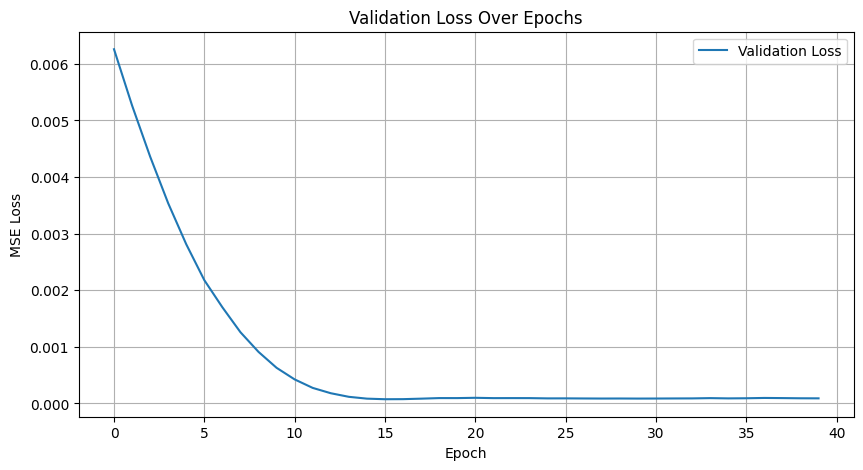

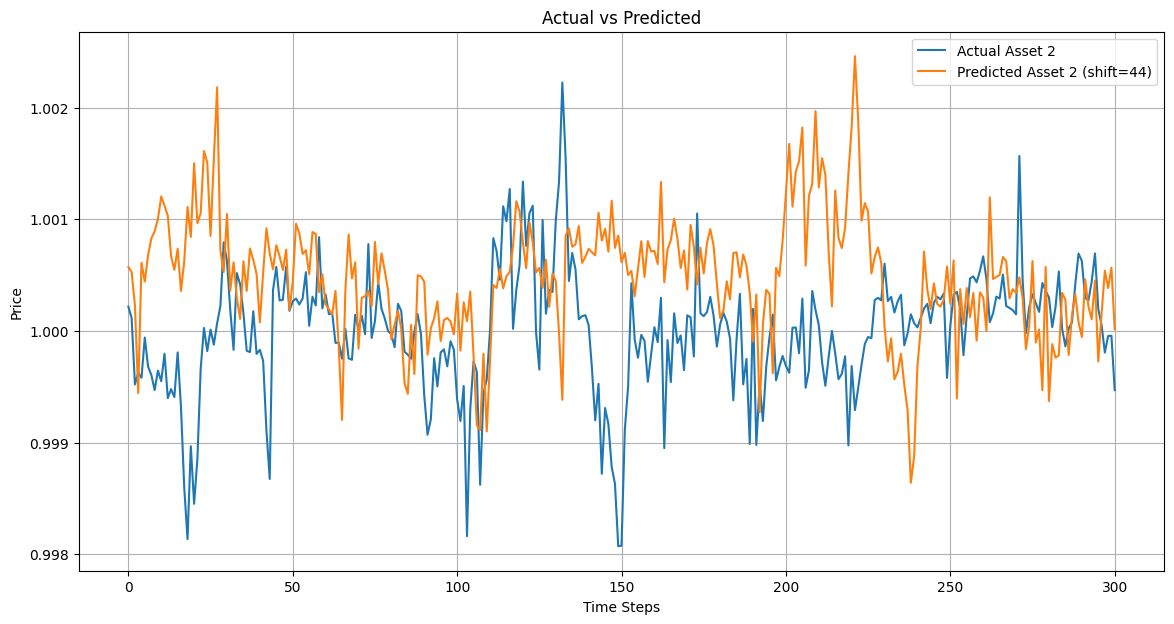

Test RMSE: 0.0010
Simulating shock...
Done.


In [97]:
model = NeuralSDEWithJump(HIDDEN_SIZE, INPUT_FEATURES, OUTPUT_SIZE, LOOKBACK).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, device, 40)
plot_val_loss(val_losses)

actual, predicted = evaluate_model(model, test_loader, tgt_scaler, device, lookback=LOOKBACK)
plot_results(actual, predicted, lookback=LOOKBACK)

print("Simulating shock...")
simulate_shock_and_predict(model, feat_scaler, tgt_scaler, combined_data, LOOKBACK, device, std_multiplier=-2)
simulate_shock_and_predict(model, feat_scaler, tgt_scaler, combined_data, LOOKBACK, device, std_multiplier=4)
print("Done.")

In [98]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import norm

# Step 1: Download historical USDT price data using yfinance
tether_data = yf.download("USDT-USD", period="1y", interval="1d")
tether_prices = tether_data['Close'].dropna().values

# Step 2: Compute real-world price *differences* (daily change, not price level)
daily_diffs = np.diff(tether_prices.reshape(-1))  
diff_std = np.std(daily_diffs, ddof=1)
diff_mad = np.median(np.abs(daily_diffs - np.mean(daily_diffs)))

print(f"Real daily change std: {diff_std:.6f}")
print(f"Real daily change MAD: {diff_mad:.6f}")

# Step 3: Your simulation
shock_range = range(-10, 11)
n_iter = 200
all_results = {std: [] for std in shock_range}

for i in range(n_iter):
    base_pred = simulate_shock_and_predict(model, feat_scaler, tgt_scaler, combined_data, LOOKBACK, device, std_multiplier=0)
    for std_mult in shock_range:
        pred = simulate_shock_and_predict(model, feat_scaler, tgt_scaler, combined_data, LOOKBACK, device, std_multiplier=std_mult)
        diff = pred - base_pred
        all_results[std_mult].append((pred, diff))

avg_results = []

for std_mult in shock_range:
    preds, diffs = zip(*all_results[std_mult])
    preds = np.array(preds)
    avg_pred = np.mean(preds)
    avg_diff = np.mean(diffs)

    # Compare avg_diff to real-world daily price movements
    z_score_diff_std = avg_diff / (diff_std if diff_std != 0 else 1e-6)
    z_score_diff_mad = avg_diff / (diff_mad if diff_mad != 0 else 1e-6)
    p_value_diff = 2 * (1 - norm.cdf(abs(z_score_diff_std)))

    avg_results.append({
        'Std_Deviation': std_mult,
        'Avg_Predicted_Price': avg_pred,
        'Avg_Difference_vs_No_Shock': avg_diff,
        'Z_Score_vs_RealPrice_STD': z_score_diff_std,
        'Z_Score_vs_RealPrice_MAD': z_score_diff_mad,
        'P_Value_vs_RealPrice': p_value_diff
    })

# Output
avg_shock_df = pd.DataFrame(avg_results)
print(avg_shock_df.to_string(index=False))


[*********************100%***********************]  1 of 1 completed

Real daily change std: 0.000379
Real daily change MAD: 0.000178


 Std_Deviation  Avg_Predicted_Price  Avg_Difference_vs_No_Shock  Z_Score_vs_RealPrice_STD  Z_Score_vs_RealPrice_MAD  P_Value_vs_RealPrice
           -10             1.000085                   -0.000571                 -1.507079                 -3.208778              0.131790
            -9             1.000143                   -0.000513                 -1.353032                 -2.880790              0.176045
            -8             1.000193                   -0.000463                 -1.221982                 -2.601768              0.221714
            -7             1.000257                   -0.000398                 -1.051044                 -2.237817              0.293238
            -6             1.000312                   -0.000344                 -0.908241                 -1.933770              0.363751
            -5             1.000370                   -0.000286                 -0.753777                 -1.604894              0.450983
            -4             1.00042

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Using device: cuda
Epoch 1/40, Train Loss: 0.0749, Val Loss: 0.1080
Epoch 2/40, Train Loss: 0.0716, Val Loss: 0.1032
Epoch 3/40, Train Loss: 0.0689, Val Loss: 0.0995
Epoch 1/40, Train Loss: 0.0749, Val Loss: 0.1080
Epoch 2/40, Train Loss: 0.0716, Val Loss: 0.1032
Epoch 3/40, Train Loss: 0.0689, Val Loss: 0.0995
Epoch 4/40, Train Loss: 0.0656, Val Loss: 0.0951
Epoch 5/40, Train Loss: 0.0627, Val Loss: 0.0908
Epoch 6/40, Train Loss: 0.0598, Val Loss: 0.0869
Epoch 4/40, Train Loss: 0.0656, Val Loss: 0.0951
Epoch 5/40, Train Loss: 0.0627, Val Loss: 0.0908
Epoch 6/40, Train Loss: 0.0598, Val Loss: 0.0869
Epoch 7/40, Train Loss: 0.0570, Val Loss: 0.0829
Epoch 8/40, Train Loss: 0.0543, Val Loss: 0.0789
Epoch 9/40, Train Loss: 0.0514, Val Loss: 0.0752
Epoch 7/40, Train Loss: 0.0570, Val Loss: 0.0829
Epoch 8/40, Train Loss: 0.0543, Val Loss: 0.0789
Epoch 9/40, Train Loss: 0.0514, Val Loss: 0.0752
Epoch 10/40, Train Loss: 0.0489, Val Loss: 0.0713
Epoch 11/40, Train Loss: 0.0462, Val Loss: 0.0672

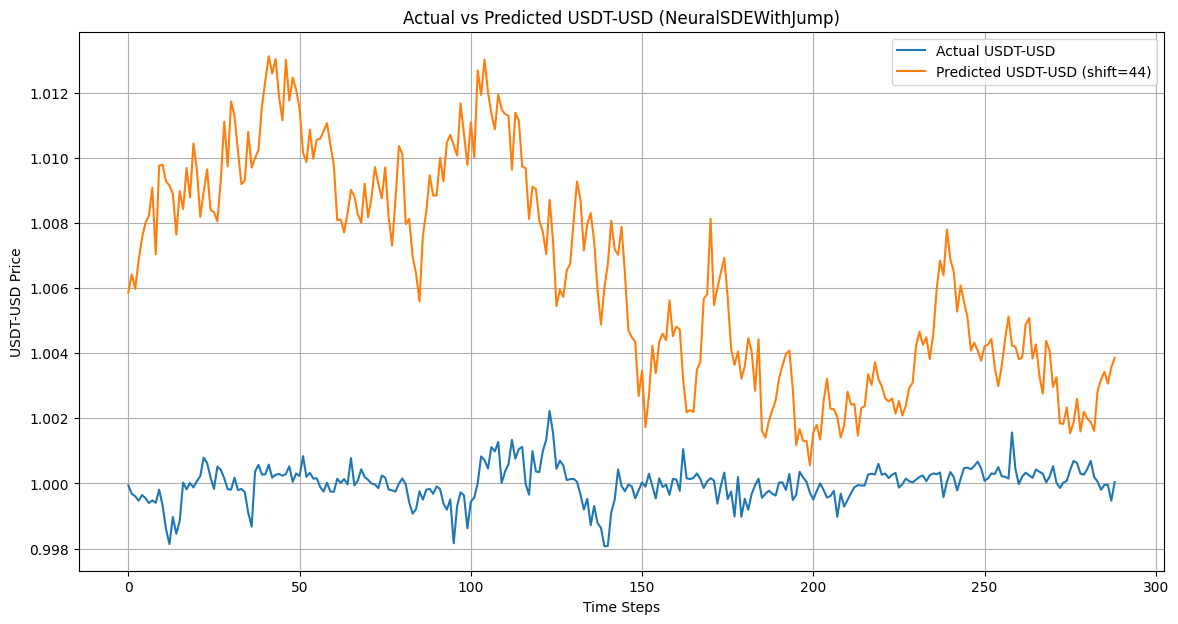

Test RMSE: 0.0072


In [99]:
# --- Predict USDT-USD using CL=F and NG=F with NeuralSDEWithJump ---
import yfinance as yf
import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils as utils
import matplotlib.pyplot as plt

# Download historical data
start_date = '2017-02-01'
end_date = '2025-10-24'
usdt = yf.download('USDT-USD', start=start_date, end=end_date)['Close'].dropna()
cl = yf.download('CL=F', start=start_date, end=end_date)['Close'].dropna()
ng = yf.download('NG=F', start=start_date, end=end_date)['Close'].dropna()

# Align indices
df = pd.concat([usdt, cl, ng], axis=1, join='inner')
df.columns = ['USDT-USD', 'CL=F', 'NG=F']

# Parameters
LOOKBACK = 44
TIME_STEP = 1
BATCH_SIZE = 256
TRAIN_SPLIT = 0.65
EPOCHS = 40
HIDDEN_SIZE = 1024
INPUT_FEATURES = 2  # CL=F and NG=F
OUTPUT_SIZE = 1
LEARNING_RATE = 1e-5

def preprocess_usdt_data(df, lookback, time_step, batch_size=64, split_ratio=0.65):
    features = df[['CL=F', 'NG=F']].values
    targets = df['USDT-USD'].values
    X_raw, y_raw = [], []
    for i in range(len(features) - lookback - time_step):
        X_raw.append(features[i:i+lookback])
        y_raw.append(targets[i+lookback+time_step])
    X_raw, y_raw = np.array(X_raw), np.array(y_raw).reshape(-1, 1)
    total_len = len(X_raw)
    train_idx = int(split_ratio * total_len)
    val_idx = int((split_ratio + (1 - split_ratio)/2) * total_len)
    X_train_raw = X_raw[:train_idx]
    y_train_raw = y_raw[:train_idx]
    X_val_raw = X_raw[train_idx:val_idx]
    y_val_raw = y_raw[train_idx:val_idx]
    X_test_raw = X_raw[val_idx:]
    y_test_raw = y_raw[val_idx:]
    feat_scaler = MinMaxScaler()
    tgt_scaler = MinMaxScaler()
    X_train = feat_scaler.fit_transform(X_train_raw.reshape(-1, features.shape[1])).reshape(X_train_raw.shape)
    X_val = feat_scaler.transform(X_val_raw.reshape(-1, features.shape[1])).reshape(X_val_raw.shape)
    X_test = feat_scaler.transform(X_test_raw.reshape(-1, features.shape[1])).reshape(X_test_raw.shape)
    y_train = tgt_scaler.fit_transform(y_train_raw)
    y_val = tgt_scaler.transform(y_val_raw)
    y_test = tgt_scaler.transform(y_test_raw)
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader, feat_scaler, tgt_scaler, X_test

class NeuralSDEWithJump(nn.Module):
    def __init__(self, hidden_size, input_features, output_size, lookback):
        super().__init__()
        self.noise_type = "diagonal"
        self.sde_type = "ito"
        self.lookback = lookback
        self.drift_lstm = nn.LSTM(input_features, hidden_size, batch_first=True)
        self.diffusion_lstm = nn.LSTM(input_features, hidden_size, batch_first=True)
        self.drift_linear = nn.Linear(hidden_size + output_size, output_size)
        self.diffusion_linear = nn.Linear(hidden_size + output_size, output_size)
        self.jump_intensity = 0.000005
        self.jump_mean = 0.0
        self.jump_std = 0.05
        self._lstm_hidden_buffer = None
    def f(self, t, y):
        if self._lstm_hidden_buffer is None:
            raise RuntimeError("LSTM hidden state not set.")
        combined = torch.cat((self._lstm_hidden_buffer, y), dim=1)
        return self.drift_linear(combined)
    def g(self, t, y):
        if self._lstm_hidden_buffer is None:
            raise RuntimeError("LSTM hidden state not set.")
        combined = torch.cat((self._lstm_hidden_buffer, y), dim=1)
        return self.diffusion_linear(combined)
    def jump(self, t, y):
        jump_prob = self.jump_intensity * 0.01
        jump_occurred = torch.bernoulli(torch.full_like(y, jump_prob))
        jump_noise = torch.randn_like(y) * self.jump_std + self.jump_mean
        return jump_occurred * jump_noise
    def forward(self, ts, y0, input_seq):
        lstm_output, (hidden, _) = self.drift_lstm(input_seq)
        self._lstm_hidden_buffer = hidden.squeeze(0)
        y = y0
        ys = [y0]
        dt = ts[1] - ts[0]
        for t in ts[1:]:
            drift = self.f(t, y)
            diffusion = self.g(t, y)
            brownian = torch.randn_like(y) * torch.sqrt(dt)
            jump = self.jump(t, y)
            y = y + drift * dt + diffusion * brownian + jump
            ys.append(y)
        ys = torch.stack(ys)
        self._lstm_hidden_buffer = None
        return ys

def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    model.train()
    val_losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            y0 = inputs[:, 0, 0].unsqueeze(1)
            ts = torch.tensor([0.0, 1.0], device=device)
            solutions = model(ts, y0, inputs)
            preds = solutions[-1]
            loss = criterion(preds, targets)
            loss.backward()
            utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_loss += loss.item()
        # --- Validation ---
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for val_inputs, val_targets in val_loader:
                val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                y0 = val_inputs[:, 0, 0].unsqueeze(1)
                ts = torch.tensor([0.0, 1.0], device=device)
                val_preds = model(ts, y0, val_inputs)[-1]
                val_loss += criterion(val_preds, val_targets).item()
        model.train()
        avg_train_loss = running_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    return val_losses

def evaluate_model(model, test_loader, target_scaler, device, lookback):
    model.eval()
    actual, predicted = [], []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            y0 = inputs[:, 0, 0].unsqueeze(1)
            ts = torch.tensor([0.0, 1.0], device=device)
            solutions = model(ts, y0, inputs)
            preds = solutions[-1]
            actual.append(targets.squeeze().detach().cpu().numpy())
            predicted.append(preds.squeeze().detach().cpu().numpy())
    actual = np.concatenate(actual)
    predicted = np.concatenate(predicted)
    actual_orig = target_scaler.inverse_transform(actual.reshape(-1, 1))
    predicted_orig = target_scaler.inverse_transform(predicted.reshape(-1, 1))
    shifted_pred = predicted_orig[:-lookback]
    actual_aligned = actual_orig[lookback:]
    return actual_aligned, shifted_pred

def plot_results(actual, predicted, lookback):
    plt.figure(figsize=(14, 7))
    plt.plot(actual, label='Actual USDT-USD')
    plt.plot(predicted, label=f'Predicted USDT-USD (shift={lookback})')
    plt.title('Actual vs Predicted USDT-USD (NeuralSDEWithJump)')
    plt.xlabel('Time Steps')
    plt.ylabel('USDT-USD Price')
    plt.legend()
    plt.grid(True)
    plt.show()
    from sklearn.metrics import mean_squared_error
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    print(f"Test RMSE: {rmse:.4f}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)
train_loader, val_loader, test_loader, feat_scaler, tgt_scaler, X_test = preprocess_usdt_data(df, LOOKBACK, TIME_STEP, BATCH_SIZE, TRAIN_SPLIT)
model = NeuralSDEWithJump(HIDDEN_SIZE, INPUT_FEATURES, OUTPUT_SIZE, LOOKBACK).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, device, EPOCHS)
actual, predicted = evaluate_model(model, test_loader, tgt_scaler, device, lookback=LOOKBACK)
plot_results(actual, predicted, lookback=LOOKBACK)


Regression coefficients: [[-0.02241956 -0.00376898]]
Regression intercept: [1.04064742]


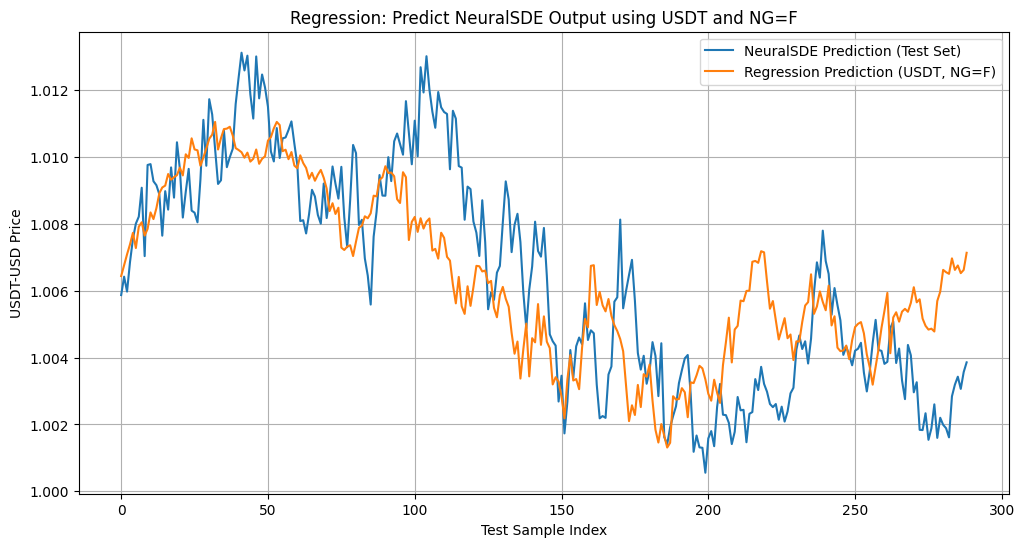

In [100]:
# --- Regression: Predict NeuralSDE predictions using USDT prices and NG=F ---
from sklearn.linear_model import LinearRegression

# Use the same df and predicted values from the previous cell
# df: columns ['USDT-USD', 'CL=F', 'NG=F']
# predicted: NeuralSDEWithJump predictions (aligned with test set)

# Align indices for regression
# Only use the test set indices for fair comparison
usdt_test = df['USDT-USD'].values[-len(predicted):]
ng_test = df['NG=F'].values[-len(predicted):]
X_reg = np.column_stack([usdt_test, ng_test])
y_reg = predicted

reg = LinearRegression()
reg.fit(X_reg, y_reg)
pred_reg = reg.predict(X_reg)

print('Regression coefficients:', reg.coef_)
print('Regression intercept:', reg.intercept_)

# Plot actual NeuralSDE predictions vs regression predictions
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_reg)), y_reg, label='NeuralSDE Prediction (Test Set)')
plt.plot(range(len(pred_reg)), pred_reg, label='Regression Prediction (USDT, NG=F)')
plt.title('Regression: Predict NeuralSDE Output using USDT and NG=F')
plt.xlabel('Test Sample Index')
plt.ylabel('USDT-USD Price')
plt.legend()
plt.grid(True)
plt.show()


[*********************100%***********************]  1 of 1 completed

VND=X Regression coefficient: [[-85879.58]]
VND=X Regression intercept: [111897.51]


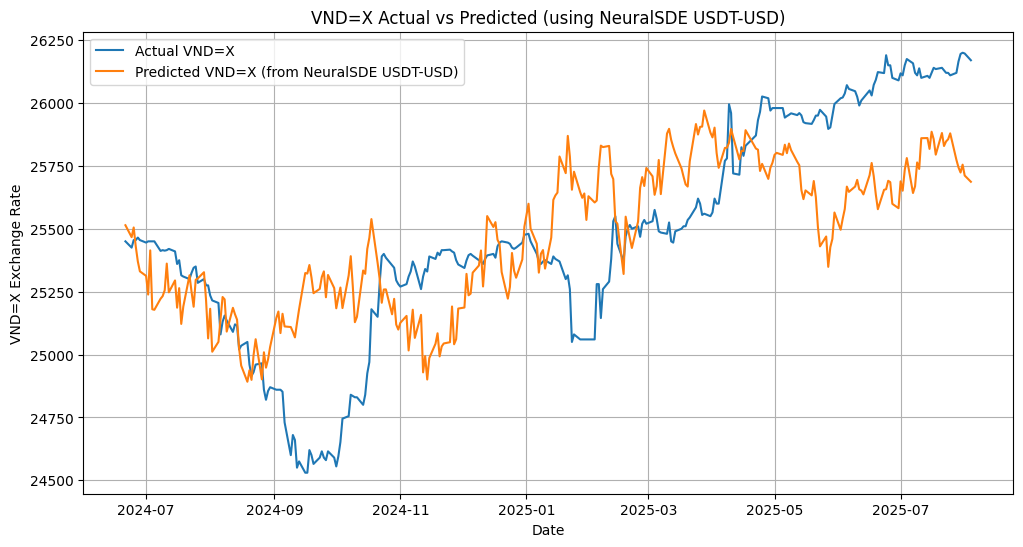

In [101]:
# --- Regression: Predict VND=X using NeuralSDE USDT-USD predictions ---
from sklearn.linear_model import LinearRegression

# Download VND=X data for the same period
vnd = yf.download('VND=X', start=start_date, end=end_date)['Close'].dropna()

# Align indices with predicted USDT-USD
vnd_aligned = vnd[-len(predicted):]

# Prepare regression features and target
X_vnd = np.array(predicted).reshape(-1, 1)
y_vnd = vnd_aligned.values

reg_vnd = LinearRegression()
reg_vnd.fit(X_vnd, y_vnd)
vnd_pred = reg_vnd.predict(X_vnd)

print('VND=X Regression coefficient:', reg_vnd.coef_)
print('VND=X Regression intercept:', reg_vnd.intercept_)

# Plot actual vs predicted VND=X
plt.figure(figsize=(12, 6))
plt.plot(vnd_aligned.index, y_vnd, label='Actual VND=X')
plt.plot(vnd_aligned.index, vnd_pred, label='Predicted VND=X (from NeuralSDE USDT-USD)')
plt.title('VND=X Actual vs Predicted (using NeuralSDE USDT-USD)')
plt.xlabel('Date')
plt.ylabel('VND=X Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()
